In [3]:
# +-----------------+
# Carga de librerías  
# +-----------------+
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

# 1) Cargar el Dataset
df = pd.read_csv(
    r"C:\Users\dvddi\OneDrive\03 Maestia en AI\07 Trabajo de graduacion\55 Data\Dataset_Congeladores_20260111.csv",
    sep=";",
    low_memory=False
)

# remover columnas "vacías" como '  '
df.columns = [c.strip() for c in df.columns]   # limpia nombres
if "" in df.columns:
    df = df.drop(columns=[""])

target = "Falla_30d"
X = df.drop(columns=[target])
y = df[target]

# 2) Split 80/20 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Clase 1 TRAIN:", y_train.mean(), " Clase 1 TEST:", y_test.mean())

# 3) Preprocesamiento (impute + scale + one-hot)
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

# 4) Transformar UNA VEZ (clave para velocidad)
print("Transformando X_train/X_test (one-hot + escalado) ...")
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

print("Transformación lista.")
print("Dimensión final X_train_enc:", X_train_enc.shape)


Train: (38048, 18)  Test: (9512, 18)
Clase 1 TRAIN: 0.07698170731707317  Clase 1 TEST: 0.07695542472666106
Transformando X_train/X_test (one-hot + escalado) ...
Transformación lista.
Dimensión final X_train_enc: (38048, 79610)


In [5]:
# +-----------------------------------+
#  Establecer métricas de los modelos 
# +----------------------------------+
def compute_metrics(name, y_true, y_pred, y_proba):
    return {
        "Modelo": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_proba)
    }


In [7]:
# +------------------+
# Regresión logística
# +-----------------+
results = []

print("Entrenando Regresión Logística")
lr = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
lr.fit(X_train_enc, y_train)
lr_pred = lr.predict(X_test_enc)
lr_proba = lr.predict_proba(X_test_enc)[:, 1]
results.append(compute_metrics("Regresión Logística", y_test, lr_pred, lr_proba))
print("Regresión logística finalizada")

Entrenando Regresión Logística
Regresión logística finalizada


In [8]:
# +--------------------------------+
# Árbol de decisión / Decision Tree
# +--------------------------------+
print("Entrenando Árbol de Decisión")
dt = DecisionTreeClassifier(max_depth=None, class_weight="balanced", random_state=42)
dt.fit(X_train_enc, y_train)
dt_pred = dt.predict(X_test_enc)
dt_proba = dt.predict_proba(X_test_enc)[:, 1]
results.append(compute_metrics("Árbol de Decisión", y_test, dt_pred, dt_proba))
print("Árbol de decisión / Decision Tree finalizado")

Entrenando Árbol de Decisión
Árbol de decisión / Decision Tree finalizado


In [10]:
# +------------+
# Random Forest
# +------------+
print("Entrenando Random Forest")
rf = RandomForestClassifier(n_estimators=80, max_depth=None, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train_enc, y_train)
rf_pred = rf.predict(X_test_enc)
rf_proba = rf.predict_proba(X_test_enc)[:, 1]
results.append(compute_metrics("Random Forest", y_test, rf_pred, rf_proba))
print("Random Forest listo")

Entrenando Random Forest
Random Forest listo


In [11]:
# +------+
# XGBoost
# +------+
print("Entrenando XGBoost")
xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=80,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=11.99,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)
xgb.fit(X_train_enc, y_train)
xgb_pred = xgb.predict(X_test_enc)
xgb_proba = xgb.predict_proba(X_test_enc)[:, 1]
results.append(compute_metrics("XGBoost", y_test, xgb_pred, xgb_proba))
print("XGB listo")

Entrenando XGBoost
XGB listo


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# -----------------------------
# Análisis de umbrales (XGBoost)
# -----------------------------
thresholds = [0.30, 0.50, 0.70]  # usa 2–3; estos son un set típico

rows = []
for thr in thresholds:
    y_pred_thr = (xgb_proba >= thr).astype(int)

    # Métricas enfocadas en la clase positiva (falla = 1)
    prec_falla = precision_score(y_test, y_pred_thr, pos_label=1, zero_division=0)
    rec_falla  = recall_score(y_test, y_pred_thr, pos_label=1, zero_division=0)
    f1_falla   = f1_score(y_test, y_pred_thr, pos_label=1, zero_division=0)

    # "Alertas" = cantidad de predicciones positivas
    alertas = int(y_pred_thr.sum())

    # Matriz de confusión para trazabilidad
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr, labels=[0, 1]).ravel()

    rows.append({
        "Umbral": thr,
        "Precision (falla)": round(prec_falla, 4),
        "Recall (falla)": round(rec_falla, 4),
        "F1-score (falla)": round(f1_falla, 4),
        "Alertas generadas": alertas,
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn)
    })

df_umbral = pd.DataFrame(rows)

print("\n--- Análisis de umbrales (XGBoost) ---")
print(df_umbral.to_string(index=False))

# Opcional: guardarlo para pegarlo en tu documento
# df_umbral.to_csv("tabla_umbrales_xgboost.csv", index=False)



--- Análisis de umbrales (XGBoost) ---
 Umbral  Precision (falla)  Recall (falla)  F1-score (falla)  Alertas generadas  TP   FP  FN   TN
    0.3             0.0779          0.9768            0.1442               9183 715 8468  17  312
    0.5             0.1026          0.5301            0.1719               3781 388 3393 344 5387
    0.7             0.1954          0.0464            0.0751                174  34  140 698 8640


In [7]:
# +--------------------------------------+
# Tabla parcial pendiente de procesar MLP
# +--------------------------------------+
results_df_partial = pd.DataFrame(results).set_index("Modelo")
results_df_partial

,Accuracy,Precision,Recall,F1-score,AUC
Modelo,,,,,
Regresión Logística,0.890244,0.108040,0.058743,0.076106,0.529031
Árbol de Decisión,0.827902,0.086758,0.129781,0.103996,0.507943
Random Forest,0.923045,0.000000,0.000000,0.000000,0.510906
XGBoost,0.607128,0.102618,0.530055,0.171948,0.593602


In [11]:
# +-------------------------------------------+
## Red neuronal densa MLP Perceptrón Multicapa
# +-------------------------------------------+

from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("Entrenando MLP")

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=1,        # entrenamos 1 iteración a la vez
    warm_start=True,   # mantiene pesos entre iteraciones
    random_state=42
)

for i in range(1, 21):
    mlp.fit(X_train_enc, y_train)
    print(f"Iteración {i}/20 completada - loss={mlp.loss_:.6f}")

print("Entrenamiento del MLP finalizado.")

mlp_pred = mlp.predict(X_test_enc)
mlp_proba = mlp.predict_proba(X_test_enc)[:, 1]

results.append(
    compute_metrics("Red Neuronal Densa (MLP)", y_test, mlp_pred, mlp_proba)
)

results_df = pd.DataFrame(results).set_index("Modelo")
results_df

Entrenando MLP
Iteración 1/20 completada - loss=0.275387
Iteración 2/20 completada - loss=0.262169
Iteración 3/20 completada - loss=0.256836
Iteración 4/20 completada - loss=0.253316
Iteración 5/20 completada - loss=0.250312
Iteración 6/20 completada - loss=0.247073
Iteración 7/20 completada - loss=0.243118
Iteración 8/20 completada - loss=0.239045
Iteración 9/20 completada - loss=0.235037
Iteración 10/20 completada - loss=0.230759
Iteración 11/20 completada - loss=0.226642
Iteración 12/20 completada - loss=0.222610
Iteración 13/20 completada - loss=0.218962
Iteración 14/20 completada - loss=0.215514
Iteración 15/20 completada - loss=0.212651
Iteración 16/20 completada - loss=0.209895
Iteración 17/20 completada - loss=0.207790
Iteración 18/20 completada - loss=0.205294
Iteración 19/20 completada - loss=0.203084
Iteración 20/20 completada - loss=0.201022
Entrenamiento del MLP finalizado.


,Accuracy,Precision,Recall,F1-score,AUC
Modelo,,,,,
Regresión Logística,0.890244,0.108040,0.058743,0.076106,0.529031
Árbol de Decisión,0.827902,0.086758,0.129781,0.103996,0.507943
Random Forest,0.923045,0.000000,0.000000,0.000000,0.510906
XGBoost,0.607128,0.102618,0.530055,0.171948,0.593602
Red Neuronal Densa (MLP),0.905278,0.103286,0.030055,0.046561,0.515859


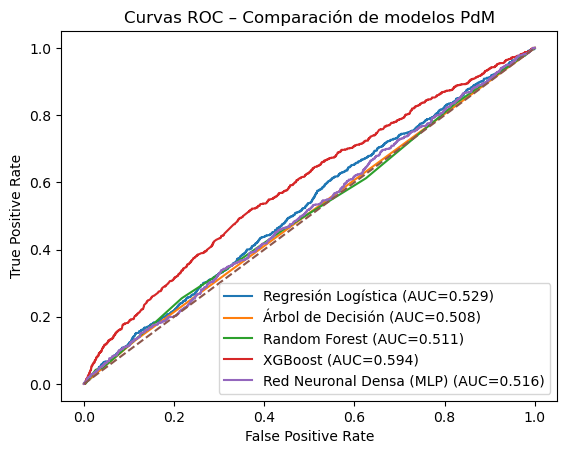

In [13]:
# +-------------------+
# Generar gráfica ROC
# +-------------------+
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predicciones de probabilidad (recalculadas explícitamente)
probs = {
    "Regresión Logística": lr.predict_proba(X_test_enc)[:, 1],
    "Árbol de Decisión": dt.predict_proba(X_test_enc)[:, 1],
    "Random Forest": rf.predict_proba(X_test_enc)[:, 1],
    "XGBoost": xgb.predict_proba(X_test_enc)[:, 1],
    "Red Neuronal Densa (MLP)": mlp.predict_proba(X_test_enc)[:, 1],
}

plt.figure()

for name, y_proba in probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

# Línea base (azar)
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – Comparación de modelos PdM")
plt.legend()
plt.show()


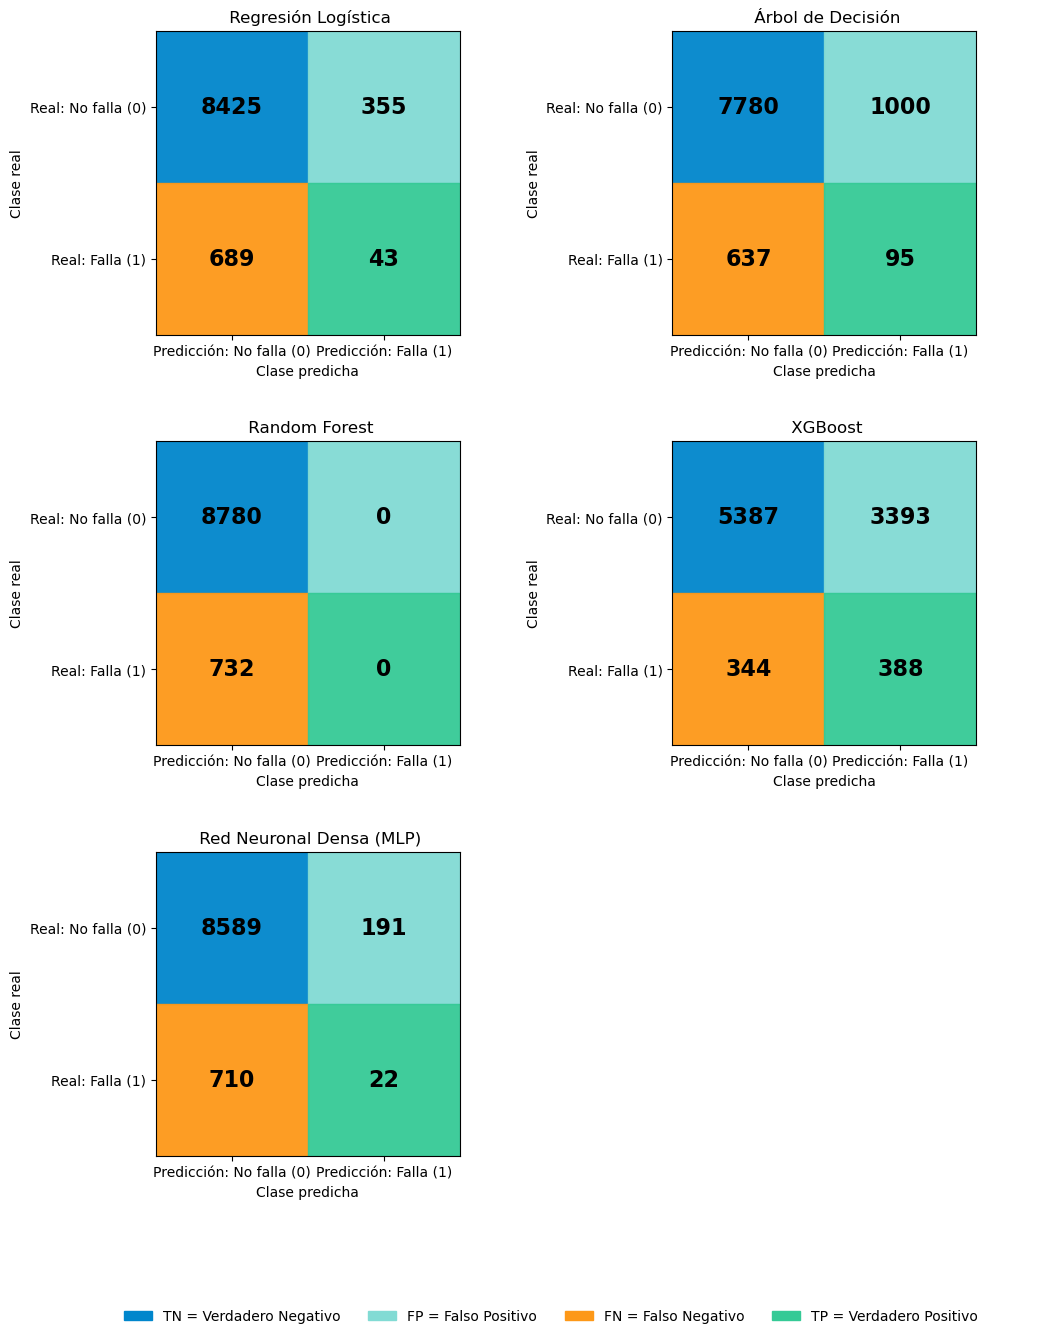

In [15]:
# +-------------------------------------------+
# Matrices de confusión para todos los modelos
# +-------------------------------------------+
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

# Colores por celda: [[TN, FP],[FN, TP]]
color_matrix = np.array([
    ["#0086CC", "#82DBD4"],  # TN, FP
    ["#FD9818", "#35CA96"]   # FN, TP
])

def plot_confusion_matrix_custom(y_true, y_pred, title, ax):
    """Matriz 2x2 con etiquetas claras (No falla/Falla + 0/1)."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Pintar cada celda y colocar el número
    for i in range(2):
        for j in range(2):
            ax.add_patch(
                plt.Rectangle((j, i), 1, 1, color=color_matrix[i, j], alpha=0.95)
            )
            ax.text(
                j + 0.5, i + 0.5, f"{cm[i, j]}",
                ha="center", va="center",
                fontsize=16, fontweight="bold", color="black"
            )

    # Configuración de ejes
    ax.set_xlim(0, 2)
    ax.set_ylim(2, 0)  # invertir eje Y
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])

    # Etiquetas explícitas con valor de clase
    ax.set_xticklabels([
        "Predicción: No falla (0)",
        "Predicción: Falla (1)"
    ])
    ax.set_yticklabels([
        "Real: No falla (0)",
        "Real: Falla (1)"
    ])

    ax.set_title(title)
    ax.set_xlabel("Clase predicha")
    ax.set_ylabel("Clase real")
    ax.set_aspect("equal")
    ax.grid(False)

# Predicciones ya calculadas
preds = {
    "Regresión Logística": lr_pred,
    "Árbol de Decisión": dt_pred,
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "Red Neuronal Densa (MLP)": mlp_pred,
}

# Crear figura (2 columnas)
n = len(preds)
cols = 2
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = np.array(axes).reshape(-1)

# Dibujar matrices
for ax, (name, y_pred) in zip(axes, preds.items()):
    plot_confusion_matrix_custom(
        y_test,
        y_pred,
        title=f" {name}",
        ax=ax
    )

# Apagar ejes sobrantes
for k in range(len(preds), len(axes)):
    axes[k].axis("off")

# Leyenda con colores por cuadrante
tn_patch = mpatches.Patch(color=color_matrix[0, 0], label="TN = Verdadero Negativo")
fp_patch = mpatches.Patch(color=color_matrix[0, 1], label="FP = Falso Positivo")
fn_patch = mpatches.Patch(color=color_matrix[1, 0], label="FN = Falso Negativo")
tp_patch = mpatches.Patch(color=color_matrix[1, 1], label="TP = Verdadero Positivo")

fig.legend(
    handles=[tn_patch, fp_patch, fn_patch, tp_patch],
    loc="lower center",
    ncol=4,
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.01)
)

# Ajustes finales
fig.subplots_adjust(bottom=0.13, hspace=0.35, wspace=0.25)

plt.show()


In [19]:
import sys
import platform
import importlib

libraries = {
    # Core
    "python": sys.version,
    "os": platform.platform(),

    # Data handling
    "numpy": "numpy",
    "pandas": "pandas",

    # Machine Learning (scikit-learn)
    "scikit-learn": "sklearn",

    # Models
    "xgboost": "xgboost",

    # Visualization
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",

    # Utilities
    "joblib": "joblib"
}

print("===== Entorno de ejecución =====")
print(f"Python: {sys.version}")
print(f"OS: {platform.platform()}")

print("\n===== Librerías utilizadas =====")
for name, lib in libraries.items():
    if lib in ["python", "os"]:
        continue
    try:
        module = importlib.import_module(lib)
        version = getattr(module, "__version__", "versión no disponible")
        print(f"{name}: {version}")
    except ImportError:
        print(f"{name}: no instalado")


===== Entorno de ejecución =====
Python: 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.19045-SP0

===== Librerías utilizadas =====
python: no instalado
os: no instalado
numpy: 1.26.4
pandas: 2.2.2
scikit-learn: 1.4.2
xgboost: 3.1.2
matplotlib: 3.8.4
seaborn: 0.13.2
joblib: 1.4.2
